In [1]:
!pip install psycopg2-binary

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor
from sklearn.metrics import accuracy_score, f1_score, mean_absolute_error, mean_squared_error
import psycopg2
from sklearn.preprocessing import StandardScaler

# 1. Load the Dataset
data = pd.read_csv('user_behavior_dataset.csv')

# Ensure numeric columns are properly converted
numeric_columns = ['App Usage Time (min/day)', 'Screen On Time (hours/day)', 
                   'Battery Drain (mAh/day)', 'Number of Apps Installed', 
                   'Data Usage (MB/day)']

for col in numeric_columns:
    data[col] = pd.to_numeric(data[col], errors='coerce')

# Drop rows with NaNs in critical numeric columns
data.dropna(subset=numeric_columns, inplace=True)

# Display initial dataset overview
print("Dataset Preview:")
print(data.head())
print("Dataset Summary:")
print(data.describe())

Dataset Preview:
   User ID    Device Model Operating System  App Usage Time (min/day)  \
0        1  Google Pixel 5          Android                       393   
1        2       OnePlus 9          Android                       268   
2        3    Xiaomi Mi 11          Android                       154   
3        4  Google Pixel 5          Android                       239   
4        5       iPhone 12              iOS                       187   

   Screen On Time (hours/day)  Battery Drain (mAh/day)  \
0                         6.4                     1872   
1                         4.7                     1331   
2                         4.0                      761   
3                         4.8                     1676   
4                         4.3                     1367   

   Number of Apps Installed  Data Usage (MB/day)  Age  Gender  \
0                        67                 1122   40    Male   
1                        42                  944   47  Female   


In [3]:
# 2. Data Preprocessing
print("Initial Dataset Shape:", data.shape)

# Handling missing values
data.fillna({
    'Operating System': 'Unknown',
    'Device Model': 'Unknown',
    'User Behavior Class': data['User Behavior Class'].mode()[0]
}, inplace=True)

# Feature Engineering: Interaction Terms
data['App_Usage_ScreenOn_Ratio'] = data['App Usage Time (min/day)'] / (data['Screen On Time (hours/day)'] + 1e-5)

# Normalizing Battery Drain
data['Battery_Drain_Normalized'] = data['Battery Drain (mAh/day)'] / data['Number of Apps Installed']

# Additional preprocessing: Standardizing numeric columns
scaler = StandardScaler()
data[['App Usage Time (min/day)', 'Screen On Time (hours/day)', 'Battery Drain (mAh/day)', 'Data Usage (MB/day)']] = scaler.fit_transform(
    data[['App Usage Time (min/day)', 'Screen On Time (hours/day)', 'Battery Drain (mAh/day)', 'Data Usage (MB/day)']]
)

# Verify preprocessing
print("Preprocessed Dataset Preview:")
print(data.head())

# 3. Connect to PostgreSQL and Store Data
try:
    conn = psycopg2.connect(
        dbname="mobile_data",
        user="user",
        password="password",
        host="localhost",
        port="5432"
    )
    cursor = conn.cursor()

    # Create tables
    cursor.execute("""
        CREATE TABLE IF NOT EXISTS user_data (
            user_id SERIAL PRIMARY KEY,
            operating_system VARCHAR(50),
            device_model VARCHAR(50),
            app_usage_time FLOAT,
            screen_on_time FLOAT,
            battery_drain FLOAT,
            user_behavior_class INT
        )
    """)

    cursor.execute("""
        CREATE TABLE IF NOT EXISTS feature_engineering (
            user_id SERIAL PRIMARY KEY,
            app_usage_screenon_ratio FLOAT,
            battery_drain_normalized FLOAT
        )
    """)

    # Insert data into the tables
    for _, row in data.iterrows():
        cursor.execute("""
            INSERT INTO user_data (operating_system, device_model, app_usage_time, screen_on_time, battery_drain, user_behavior_class)
            VALUES (%s, %s, %s, %s, %s, %s)
        """, (row['Operating System'], row['Device Model'], row['App Usage Time (min/day)'],
              row['Screen On Time (hours/day)'], row['Battery Drain (mAh/day)'], row['User Behavior Class']))

        cursor.execute("""
            INSERT INTO feature_engineering (app_usage_screenon_ratio, battery_drain_normalized)
            VALUES (%s, %s)
        """, (row['App_Usage_ScreenOn_Ratio'], row['Battery_Drain_Normalized']))

    conn.commit()
    print("Data inserted into PostgreSQL successfully!")

    # Verify insertion by counting rows in user_data
    cursor.execute("SELECT COUNT(*) FROM user_data;")
    count_user_data = cursor.fetchone()[0]
    print(f"Number of rows in user_data: {count_user_data}")

    # Retrieve sample data from user_data to verify insertion
    cursor.execute("SELECT * FROM user_data LIMIT 5;")
    rows_user = cursor.fetchall()
    print("Sample data retrieved from user_data:", rows_user)

    # Retrieve sample data from feature_engineering to verify insertion
    cursor.execute("SELECT * FROM feature_engineering LIMIT 5;")
    rows_feature = cursor.fetchall()
    print("Sample data retrieved from feature_engineering:", rows_feature)

except Exception as e:
    print("Database error:", e)
finally:
    try:
        if 'conn' in locals() and conn is not None:
            cursor.close()
            conn.close()
            print("Database connection closed.")
    except Exception as e:
        print("Error while closing the connection:", e)

Initial Dataset Shape: (700, 11)
Preprocessed Dataset Preview:
   User ID    Device Model Operating System  App Usage Time (min/day)  \
0        1  Google Pixel 5          Android                  0.688256   
1        2       OnePlus 9          Android                 -0.017668   
2        3    Xiaomi Mi 11          Android                 -0.661471   
3        4  Google Pixel 5          Android                 -0.181443   
4        5       iPhone 12              iOS                 -0.475107   

   Screen On Time (hours/day)  Battery Drain (mAh/day)  \
0                    0.367626                 0.423726   
1                   -0.186771                -0.237198   
2                   -0.415053                -0.933550   
3                   -0.154160                 0.184279   
4                   -0.317218                -0.193218   

   Number of Apps Installed  Data Usage (MB/day)  Age  Gender  \
0                        67             0.300405   40    Male   
1                  

In [ ]:
# 4. Exploratory Data Analysis
sns.pairplot(data, hue='User Behavior Class')
plt.show()

# Correlation Heatmap
# Select only numeric columns
numeric_data = data.select_dtypes(include=['number'])  # Select numeric columns only

# Compute correlation matrix
correlation_matrix = numeric_data.corr()

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

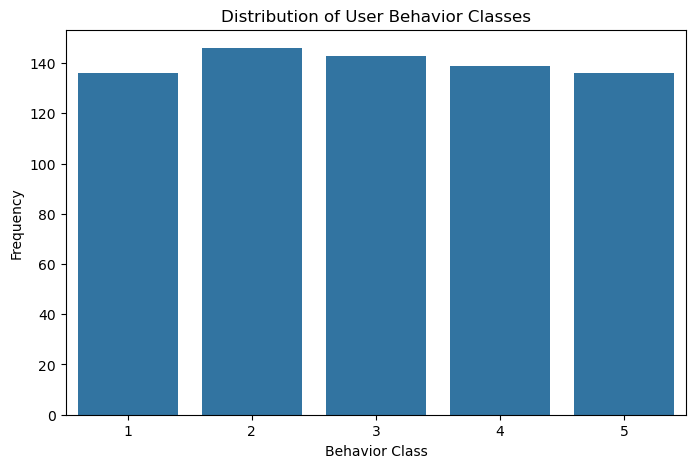

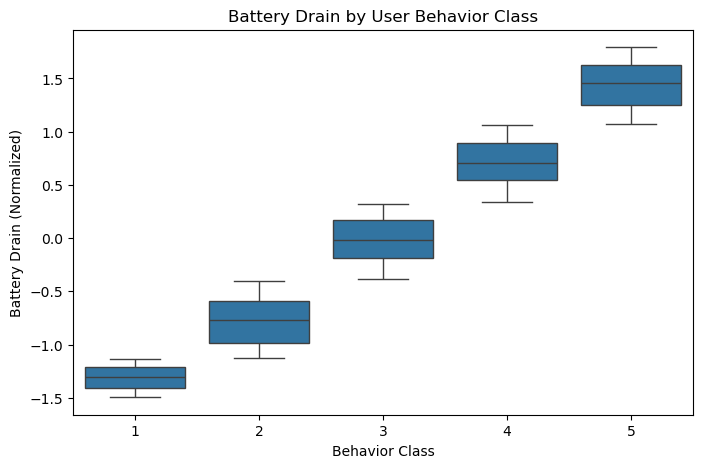

In [5]:
# EDA: Distribution of User Behavior Classes
plt.figure(figsize=(8, 5))
sns.countplot(x='User Behavior Class', data=data)
plt.title('Distribution of User Behavior Classes')
plt.xlabel('Behavior Class')
plt.ylabel('Frequency')
plt.show()

# EDA: Boxplot of Battery Drain by Behavior Class
plt.figure(figsize=(8, 5))
sns.boxplot(x='User Behavior Class', y='Battery Drain (mAh/day)', data=data)
plt.title('Battery Drain by User Behavior Class')
plt.xlabel('Behavior Class')
plt.ylabel('Battery Drain (Normalized)')
plt.show()

In [6]:
# 5. Modeling
# Splitting Data
X = data[['App Usage Time (min/day)', 'Screen On Time (hours/day)', 'Battery Drain (mAh/day)', 'App_Usage_ScreenOn_Ratio']]
y_class = data['User Behavior Class']
y_regress = data['Battery Drain (mAh/day)']

X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X, y_class, test_size=0.2, random_state=42)
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X, y_regress, test_size=0.2, random_state=42)

# Classification Model
classifier = RandomForestClassifier(random_state=42, n_estimators=100, max_depth=10)
classifier.fit(X_train_class, y_train_class)

# Regression Model
regressor = GradientBoostingRegressor(random_state=42, n_estimators=100, learning_rate=0.1, max_depth=5)
regressor.fit(X_train_reg, y_train_reg)

GradientBoostingRegressor(max_depth=5, random_state=42)

In [7]:
# 6. Evaluation
# Classification Metrics
y_pred_class = classifier.predict(X_test_class)
print("Classification Accuracy:", accuracy_score(y_test_class, y_pred_class))
print("Classification F1 Score:", f1_score(y_test_class, y_pred_class, average='weighted'))

# Regression Metrics
y_pred_reg = regressor.predict(X_test_reg)
print("Regression MAE:", mean_absolute_error(y_test_reg, y_pred_reg))
print("Regression RMSE:", np.sqrt(mean_squared_error(y_test_reg, y_pred_reg)))

Classification Accuracy: 1.0
Classification F1 Score: 1.0
Regression MAE: 0.0030529081762173146
Regression RMSE: 0.004284670845665969


In [ ]:
# 7. Advanced Analysis: Feature Importance
# Classification Feature Importance
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': classifier.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance for Classification')
plt.show()

# Regression Feature Importance
feature_importance_reg = pd.DataFrame({
    'Feature': X.columns,
    'Importance': regressor.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(x='Importance', y='Feature', data=feature_importance_reg)
plt.title('Feature Importance for Regression')
plt.show()

In [ ]:
# 8. Visualization of Predictions
# Classification
sns.histplot(y_test_class, label='True Classes', kde=True, color='blue')
sns.histplot(y_pred_class, label='Predicted Classes', kde=True, color='orange')
plt.legend()
plt.title('True vs Predicted Classes')
plt.show()

# Regression
plt.scatter(y_test_reg, y_pred_reg, alpha=0.6, edgecolors='w')
plt.xlabel('True Battery Drain')
plt.ylabel('Predicted Battery Drain')
plt.title('True vs Predicted Battery Drain')
plt.show()

# 9. Documentation and Reporting
print("Summary of Key Findings:")
print("1. Classification achieved an accuracy of {:.2f}% with significant predictors like App Usage Time and Screen On Time.".format(accuracy_score(y_test_class, y_pred_class) * 100))
print("2. Regression MAE indicates a typical error margin of {:.2f} units for predicting battery drain.".format(mean_absolute_error(y_test_reg, y_pred_reg)))
print("3. Feature importance analysis highlights App Usage Time as the most influential predictor for both tasks.")